In [24]:
#plots
import matplotlib.pylab as plt
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()

#data
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
import json
from collections import OrderedDict
from scipy.stats import norm as gauss
import random
from random import shuffle

#ML
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import keras
from keras import objectives
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Multiply, Add, Lambda, Layer
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D
from keras.optimizers import Adam, Nadam
from keras.objectives import binary_crossentropy #objs or losses

#chem
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
import salty

#misc/scripts
import sys
sys.path.insert(0, '../')
from scripts import *

vae_models = ['Bootstrap_250k_Cation_1.h5', 'Bootstrap_1Mil_Cation_1.h5',
    '1Mil_GDB17.h5', '1Mil_GDB17_split_500k.h5', '1Mil_GDB17_split_500k_cation_500k.h5']

#search with single seed data
df1 = pd.read_csv('../scripts/vae_1_structures.csv')
df2 = pd.read_csv('../scripts/vae_2_structures.csv')
df3 = pd.read_csv('../scripts/vae_3_structures.csv')
df4 = pd.read_csv('../scripts/vae_4_structures.csv')
df5 = pd.read_csv('../scripts/vae_5_structures.csv')
dfs = [df1, df2, df3, df4, df5]

#salt data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
salts = pd.read_csv('../data/salts.csv')
salts = salts['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]
salt_coldic = pd.read_csv('../data/salt_coldic.csv')
salt_coldic = salt_coldic.to_dict(orient='records')[0]
salt_categories = pd.read_csv('../data/salt_categories.csv')
salt_categories = salt_categories['category']

In [3]:
f = open("../data/1mil_GDB17.json","r")
char_to_index = json.loads(f.read())
char_to_index['.'] = 33
char_to_index['@'] = 34
char_to_index['e'] = 35
char_to_index['/'] = 36
json = json.dumps(char_to_index)
f = open("../data/salt_char_to_index.json","w")
f.write(json)
f.close()

**evolution of the latent space**

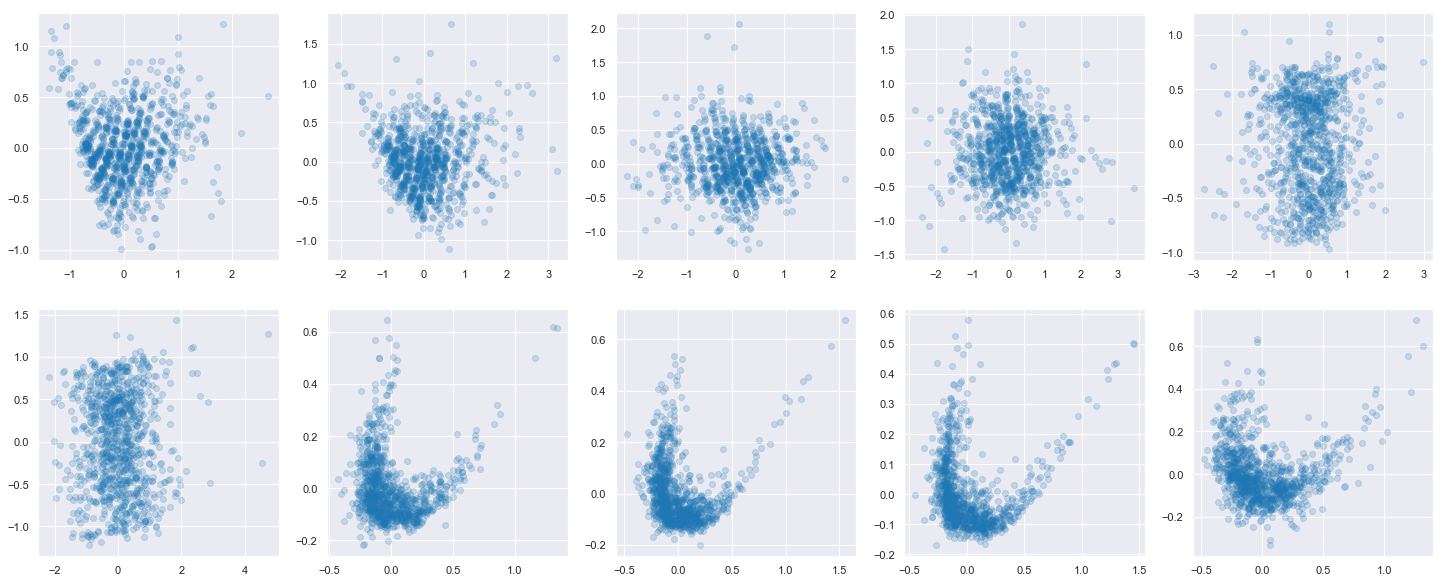

In [11]:
#For loop to save semi-trained model to
#view PCAs and Z distributions during training

#training array info
smile_max_length = 105
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#figure
fig, axs = plt.subplots(2,5, figsize=(25,10))
axs = axs.ravel()
colors = my_colors() 
latent_embeddings = []

#training data
df = pd.read_csv('../data/GDB/GDB17.1000000', names=['smiles'])
data_size = 100000
max_data = df.shape[0]
chemvae = MoleculeVAE()

for p in range(0,1):
    selected = df['smiles'][data_size*p:data_size*(p+1)].reset_index(drop=True)
    values = pd.Series(selected.values + '.' + selected[::-1].values)
    
    for model in range(0,10): #plot of training data only
        chemvae.create(char_set, max_length=smile_max_length, 
                       weights_file='gen2_2mol_1mil_GDB17_5_2_mix_5_2_cat{}.h5'.format(model+1))
        z = []
        for smi in random.sample(set(values), 1000):
            z_i = chemvae.encoder.predict(one_hot(smi, char_to_index, 
                                                  smile_max_length=smile_max_length))
            z.append(z_i[0])
        z = np.array(z)
        latent_embeddings.append(z)
        pca = PCA(n_components=2)
        pcs = pca.fit_transform(z)
        
        axs[model].plot(pcs[:,0], 
                        pcs[:,1],
                 linestyle='', marker='.', markersize=12,
                    color='tab:blue', alpha=0.2)
latent_embeddings = np.array(latent_embeddings)

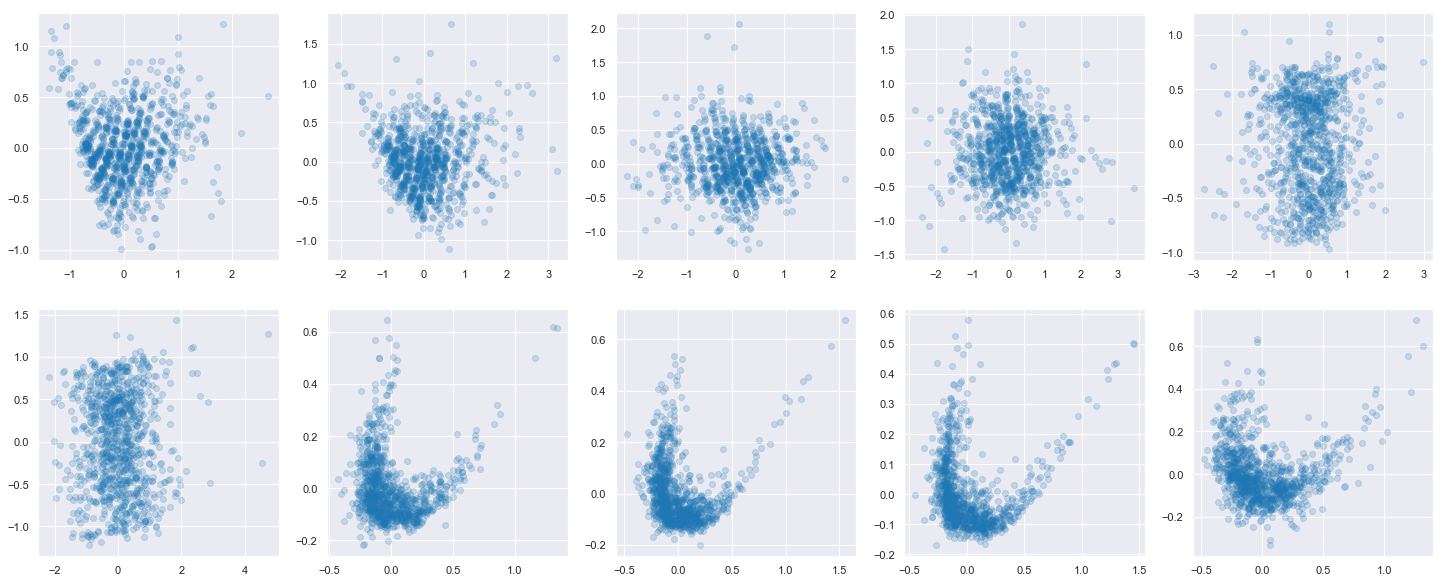

In [11]:
#For loop to save semi-trained model to
#view PCAs and Z distributions during training

#training array info
smile_max_length = 105
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#figure
fig, axs = plt.subplots(2,5, figsize=(25,10))
axs = axs.ravel()
colors = my_colors() 
latent_embeddings = []

#training data
df = pd.read_csv('../data/GDB/GDB17.1000000', names=['smiles'])
data_size = 100000
max_data = df.shape[0]
chemvae = MoleculeVAE()

for p in range(0,1):
    selected = df['smiles'][data_size*p:data_size*(p+1)].reset_index(drop=True)
    values = pd.Series(selected.values + '.' + selected[::-1].values)
    
    for model in range(0,10): #plot of training data only
        chemvae.create(char_set, max_length=smile_max_length, 
                       weights_file='gen2_2mol_1mil_GDB17_{}.h5'.format(model+1))
        z = []
        for smi in random.sample(set(values), 1000):
            z_i = chemvae.encoder.predict(one_hot(smi, char_to_index, 
                                                  smile_max_length=smile_max_length))
            z.append(z_i[0])
        z = np.array(z)
        latent_embeddings.append(z)
        pca = PCA(n_components=2)
        pcs = pca.fit_transform(z)
        
        axs[model].plot(pcs[:,0], 
                        pcs[:,1],
                 linestyle='', marker='.', markersize=12,
                    color='tab:blue', alpha=0.2)
latent_embeddings = np.array(latent_embeddings)

In [2]:
wes = 'wes'
'{}'.format(wes)

'wes'

In [12]:
np.save('gen2_2mol_1mil_GDB17_latent_embeddings', latent_embeddings)

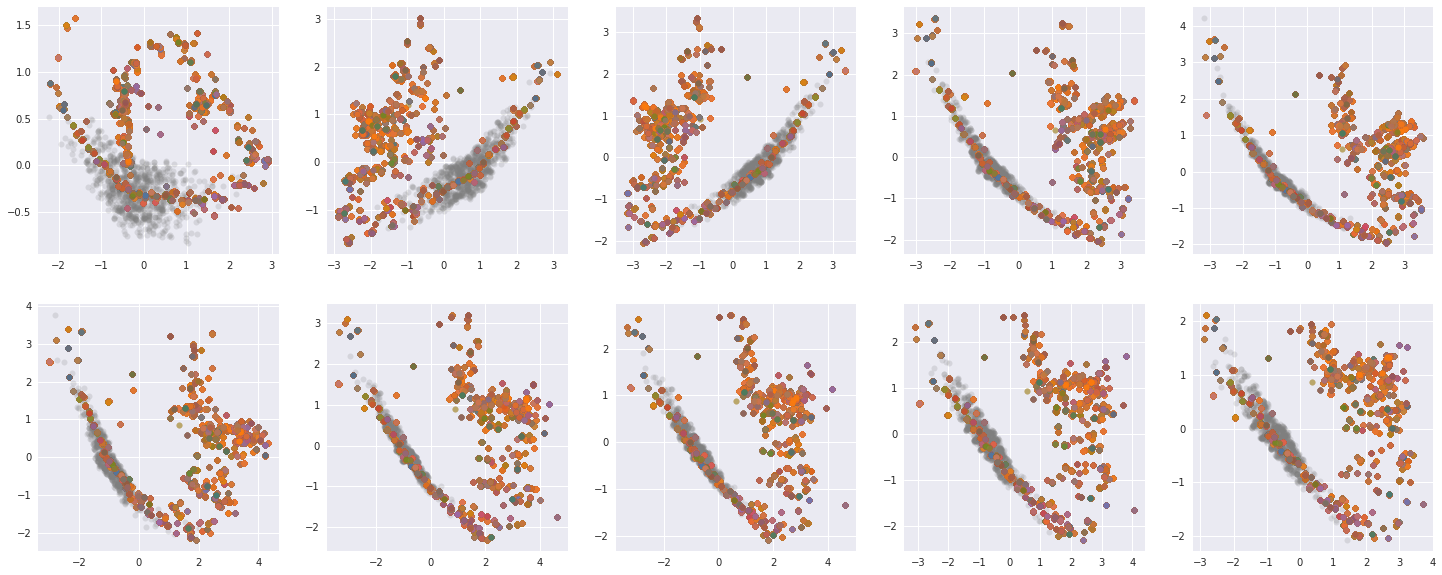

In [25]:
#For loop to save semi-trained model to
#view PCAs and Z distributions during training
import random

#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())

char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#figure
fig, axs = plt.subplots(2,5, figsize=(25,10))
axs = axs.ravel()
colors = my_colors() 
latent_embeddings = []

#training data
chemvae = MoleculeVAE()
index=0
for p in range(1,6):
    df = pd.read_csv('../data/GDB/GDB17.{}000000'.format(p+1), names=['smiles'])
    selected = df['smiles']
    values = pd.Series(selected.values + '.' + selected[::-1].values)
    color = 'tab:blue'
    for model in range(1,3):
        chemvae.create(char_set, max_length=smile_max_length, weights_file='gen2_2mol_50mil_GDB17_5_2_mix_{}_{}.h5'.format(p, model))
        z = []
        for smi in values[:1000]:
            z_i = chemvae.encoder.predict(one_hot(smi, char_to_index, smile_max_length=smile_max_length))
            z.append(z_i[0])
        for smi in salts:
            z_i = chemvae.encoder.predict(one_hot(smi[:104], char_to_index, smile_max_length=smile_max_length))
            z.append(z_i[0])
        z = np.array(z)
        latent_embeddings.append(z)
        pca = PCA(n_components=2)
        pcs = pca.fit_transform(z)
        
        axs[index].plot(pcs[:1000,0], 
                        pcs[:1000,1],
                 linestyle='', marker='.', markersize=12,
                    color='tab:grey', alpha=0.2)
        for i in range(len(salt_categories)):
            axs[index].plot(pcs[1000+i:,0], 
                            pcs[1000+i:,1],
                     linestyle='', marker='.', markersize=12,
                        color=salt_coldic[salt_categories[i]], alpha=0.2)
        index += 1
latent_embeddings = np.array(latent_embeddings)

In [26]:
np.save('gen2_2mol_6mil_GDB17_mix_latent_embeddings_with_salts', latent_embeddings)

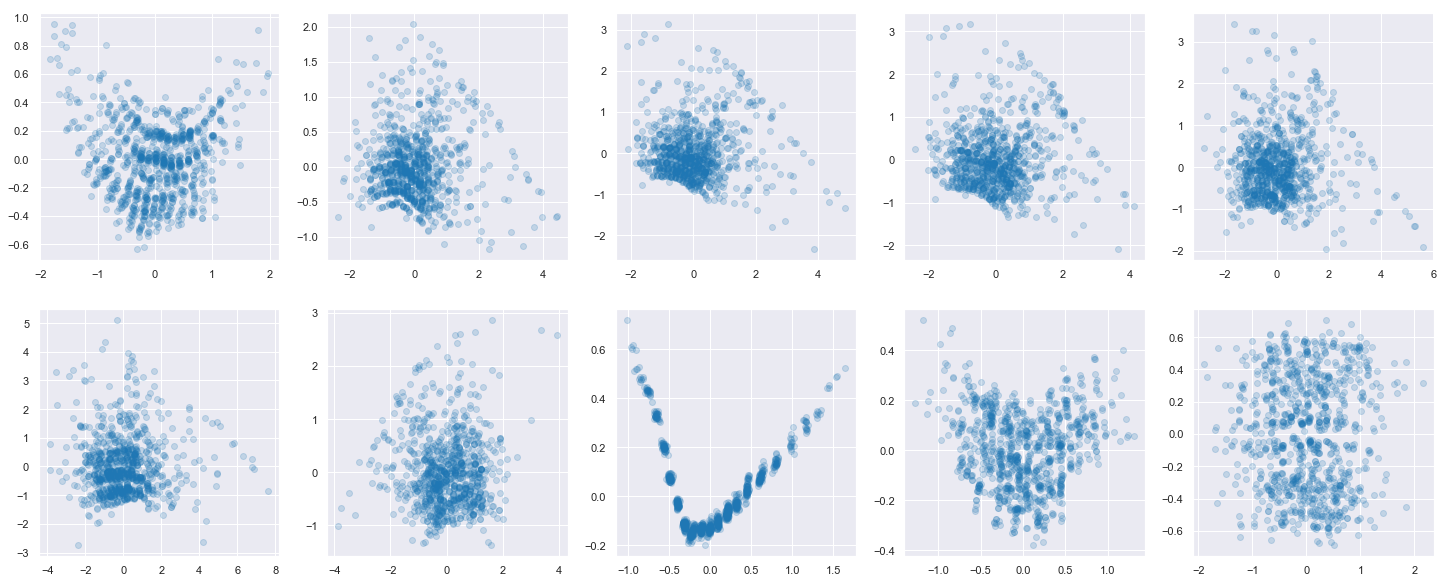

In [6]:
#For loop to save semi-trained model to
#view PCAs and Z distributions during training
import random

#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())

char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#figure
fig, axs = plt.subplots(2,5, figsize=(25,10))
axs = axs.ravel()
colors = my_colors() 
latent_embeddings = []

#training data
chemvae = MoleculeVAE()
index=0
for p in range(1,6):
    df = pd.read_csv('../data/GDB/GDB17.{}000000'.format(p+1), names=['smiles'])
    selected = df['smiles']
    values = pd.Series(selected.values + '.' + selected[::-1].values)
    color = 'tab:blue'
    for model in range(1,3):
        chemvae.create(char_set, max_length=smile_max_length, weights_file='gen2_2mol_50mil_GDB17_{}_{}.h5'.format(p, model))
        z = []
        for smi in values[:1000]:
            z_i = chemvae.encoder.predict(one_hot(smi, char_to_index, smile_max_length=smile_max_length))
            z.append(z_i[0])
        z = np.array(z)
        latent_embeddings.append(z)
        pca = PCA(n_components=2)
        pcs = pca.fit_transform(z)
        
        axs[index].plot(pcs[:,0], 
                        pcs[:,1],
                 linestyle='', marker='.', markersize=12,
                    color=color, alpha=0.2)
        index += 1
latent_embeddings = np.array(latent_embeddings)

In [7]:
np.save('gen2_2mol_6mil_GDB17_latent_embeddings', latent_embeddings)

**salt stuff**

In [2]:
#for getting cation data
properties = ['density', 'cpt', 'viscosity', 'thermal_conductivity',
              'melting_point']
props = properties
devmodel = salty.aggregate_data(props, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation']
cations = devmodel.Data['smiles_string'].drop_duplicates()
cations = cations.reset_index(drop=True)

In [9]:
categories = []
for salt in salts:
    category = salty.assign_category(pd.DataFrame([salty.check_name(salt.split(".")[0])],
                                                  columns=['name-cation']))['category'][0]
    categories.append(category)
coldic = {}
tab = my_colors()
for cat in pd.DataFrame(categories)[0].unique():
    coldic[cat] = next(tab)
pd.DataFrame(coldic,index=[0]).to_csv('../data/salt_coldic.csv',index=False)
pd.DataFrame(categories, columns=['category']).to_csv('../data/salt_categories.csv', index=False)

ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 1
['1-phenyl-3,5-dimethyl-2-pentylpyrazolium']
ILs labeled as other: 1
['1-phenyl-3,5-dimethyl-2-hexylpyrazolium']
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 1
['N,N-dimethylformamide']
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 1
['N-me

**cation stuff**

In [2]:
#for getting cation data
properties = ['density', 'cpt', 'viscosity', 'thermal_conductivity',
              'melting_point']
props = properties
devmodel = salty.aggregate_data(props, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation']
cations = devmodel.Data['smiles_string'].drop_duplicates()
cations = cations.reset_index(drop=True)

In [3]:
categories = []
for cation in cations:
    category = salty.assign_category(pd.DataFrame([salty.check_name(cation)],
                                                  columns=['name-cation']))['category'][0]
    categories.append(category)
coldic = {}
tab = my_colors()
for cat in pd.DataFrame(categories)[0].unique():
    coldic[cat] = next(tab)
pd.DataFrame(coldic,index=[0]).to_csv('../data/coldic.csv',index=False)
pd.DataFrame(categories, columns=['category']).to_csv('../data/categories.csv', index=False)

ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 1
['1-phenyl-3,5-dimethyl-2-pentylpyrazolium']
ILs labeled as other: 1
['1-phenyl-3,5-dimethyl-2-hexylpyrazolium']
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 1
['N,N-dimethylformamide']
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 1
['N-me

In [4]:
weights_file = "../data/{}".format(vae_models[-1])
f = open("../data/1mil_GDB17.json","r")
char_to_index = json.loads(f.read())
chemvae = MoleculeVAE()
char_set = set(char_to_index.keys())
chemvae.load(char_set, weights_file)

In [5]:
z = []
for smi in cations:
    z_i = chemvae.encoder.predict(one_hot(smi, char_to_index))
    z.append(z_i[0])
z = np.array(z)
pca = PCA(n_components=2)
pca.fit_transform(z)

array([[ 1.2123871e+00,  1.3895018e-01],
       [ 1.1052880e+00, -1.2599427e-01],
       [ 1.0473067e+00, -1.6538024e-02],
       [ 8.3113962e-01, -3.2014447e-01],
       [ 3.2980841e-02, -6.2591296e-01],
       [-1.1626425e+00, -8.0050480e-01],
       [-1.1780212e+00, -9.9106157e-01],
       [-7.9511893e-01, -2.2529797e-01],
       [ 6.0465759e-01,  7.4419510e-01],
       [ 1.1970066e+00, -9.4829097e-02],
       [ 3.0396241e-01, -4.8533520e-01],
       [ 1.1326172e+00,  2.2754833e-01],
       [ 1.2866087e+00,  1.2653475e-01],
       [ 5.8819336e-01, -3.7609586e-01],
       [-1.2848260e-01, -4.6022782e-01],
       [ 3.1123298e-01,  7.8529555e-01],
       [ 2.2257430e-02,  1.0258404e+00],
       [-2.7063408e-01, -3.9371890e-01],
       [ 2.3073089e+00,  2.7681595e-01],
       [ 6.0838133e-01, -1.8572895e-01],
       [ 1.1279657e+00, -3.4427860e-01],
       [ 1.5315260e+00,  6.9351804e-01],
       [-4.6286198e-01, -5.2284610e-01],
       [-4.0034178e-01, -4.5411846e-01],
       [ 1.12061

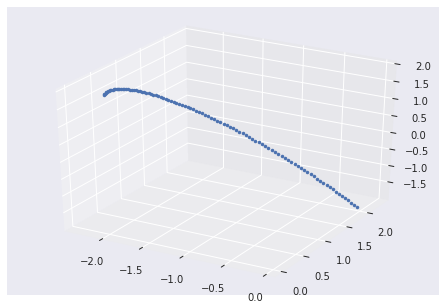

In [6]:
# example of the SLERP
if __name__ == '__main__':
    pA = array([-2.0, 0.0, 2.0])
    pB = array([0.0, 2.0, -2.0])

    ps = array([slerp(pA, pB, t) for t in arange(0.0, 1.0, 0.01)])

    from pylab import *
    from mpl_toolkits.mplot3d import Axes3D
    f = figure()
    ax = Axes3D(f)
    ax.plot3D(ps[:,0], ps[:,1], ps[:,2], '.')
    show()

In [72]:
cat1 = z[181]
cat2 = z[242]

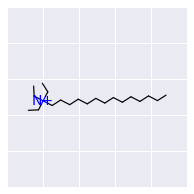

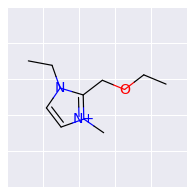

In [74]:
im1 = Draw.MolToMPL(Chem.MolFromSmiles(cations[181]), size=(100,100))
im2 = Draw.MolToMPL(Chem.MolFromSmiles(cations[242]), size=(100,100))

In [84]:
# we can interpolate between these molecules...
ps = array([slerp(cat1, cat2, t) for t in arange(0.0, 1.0, 0.1)])
pca.transform(ps)

array([[-1.1553673 ,  0.5685917 ],
       [-1.0391078 ,  0.57513607],
       [-0.9204312 ,  0.5682979 ],
       [-0.80208266,  0.5482339 ],
       [-0.6868001 ,  0.5154095 ],
       [-0.5772498 ,  0.47058302],
       [-0.47596672,  0.4147923 ],
       [-0.38529333,  0.34932745],
       [-0.3073274 ,  0.2757027 ],
       [-0.24387273,  0.19562192]], dtype=float32)

181
242


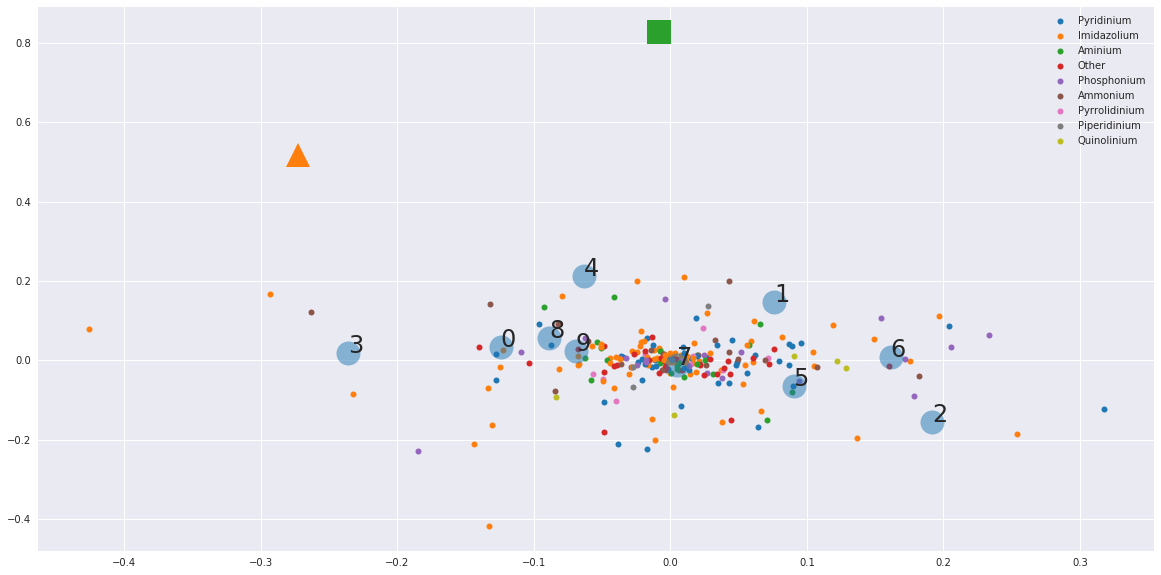

In [85]:
from collections import OrderedDict
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
for i in range(len(categories)):
    x = np.sum(np.dot(pca.components_[0,i],z[i,:]))
    y = np.sum(np.dot(pca.components_[1,i],z[i,:]))
    if y >0.4:
        print(i)
    if i == 181:
        ax1.plot(x, y, linestyle='', marker='s', 
                 color=coldic[categories[i]], markersize=24, label=categories[i])
    if i == 242:
        ax1.plot(x, y, linestyle='', marker='^', 
                 color=coldic[categories[i]], markersize=24, label=categories[i])
    ax1.plot(x, y, linestyle='', marker='.', 
             color=coldic[categories[i]], markersize=12, label=categories[i])

# for viewing the PCs of the embeded inerpolations
for i in range(ps.shape[0]):
    x = np.sum(np.dot(pca.components_[0,i],ps[i,:]))
    y = np.sum(np.dot(pca.components_[1,i],ps[i,:]))
    ax1.plot(x, y,
            linestyle='', marker='o', color='tab:blue', markersize=24, alpha=0.5)
    ax1.text(x, y, '{}'.format(i), fontsize=24)
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

Now lets generate structures between those two points...

In [86]:
def interpolate_structures(vae, ps, char_to_index, limit=1e4, write=False, temp=0.5):
    """
    Quick and Dirty: 
    Use this VAE, these interpolations of embeded z's, and this char_to_index
    dictionary to randomly generate structures at temp
    """
    rdkit_mols = []
    temps = []
    iterations = []
    iteration = limit_counter = 0
    df = pd.DataFrame()
    for p in ps:
        while True:
            iteration += 1
            limit_counter += 1
            t = temp
            candidate = decode_latent(chemvae, p.reshape(1,292), char_to_index, temp=t)
            try:
                sampled = Chem.MolFromSmiles(candidate)
                cation = Chem.AddHs(sampled)
                Chem.EmbedMolecule(cation, Chem.ETKDG())
                Chem.UFFOptimizeMolecule(cation)
                cation = Chem.RemoveHs(cation)
                candidate = Chem.MolToSmiles(cation)
                if candidate not in rdkit_mols:
                    temps.append(t)
                    iterations.append(iteration)
                    rdkit_mols.append(candidate) 
                    limit_counter = 0
                    df = pd.DataFrame([rdkit_mols,temps,iterations]).T
                    df.columns = ['smiles', 'temperature', 'iteration']
                    print(df)
                    print(t)
                    break
            except:
                pass
            if limit_counter > limit:
                break
        if write:
            df = pd.DataFrame([rdkit_mols,temps,iterations]).T
            df.columns = ['smiles', 'temperature', 'iteration']
            pd.DataFrame.to_csv(df, path_or_buf='{}.csv'.format(write), index=False)
    return df
    
def decode_latent(vae, z, char_to_index, temp=0.5, smile_max_length=51):
    """
    vae: variational autoencoder to encode/decode input
    smi: smiles string to encode
    temp: temperature at which to perform sampling
    """
    char_list = list(char_to_index.keys())
    index_to_char = dict((i, c) for i, c in enumerate(char_list))
    string = ""
    for i in vae.decoder.predict(z):
        for j in i:
            index = sample(j, temperature=temp)
            string += index_to_char[index]
    return string

In [87]:
df = interpolate_structures(chemvae, ps, char_to_index, limit=1e4, temp=0.25)

                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25         1
0.25
                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25         1
1  CCCCCCCCCCCCCC[C+](CC)(CC)CC        0.25        72
0.25
                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25         1
1  CCCCCCCCCCCCCC[C+](CC)(CC)CC        0.25        72
2   CCCCCCCCCCCCCC[C+](C)(CC)CC        0.25        73
0.25
                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25         1
1  CCCCCCCCCCCCCC[C+](CC)(CC)CC        0.25        72
2   CCCCCCCCCCCCCC[C+](C)(CC)CC        0.25        73
3   CCCCCCCCCCCCCC[N+](O)(CC)CC        0.25       195
0.25
                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25         1
1  CCCCCCCCCCCCCC[C+](CC)(CC)CC        0.25        72
2   CCCCCCCCCCCCCC[C+](C)(CC)CC        0.25        73
3   CCCC

In [107]:
df.to_csv('../data/cation_interpolation.csv', index=False)

In [109]:
pd.DataFrame(cations).to_csv('../data/cations.csv', index=False)

In [103]:
ms = [i for i in df['smiles']]
ms.insert(0, cations[181])
ms.insert(-1, cations[242])

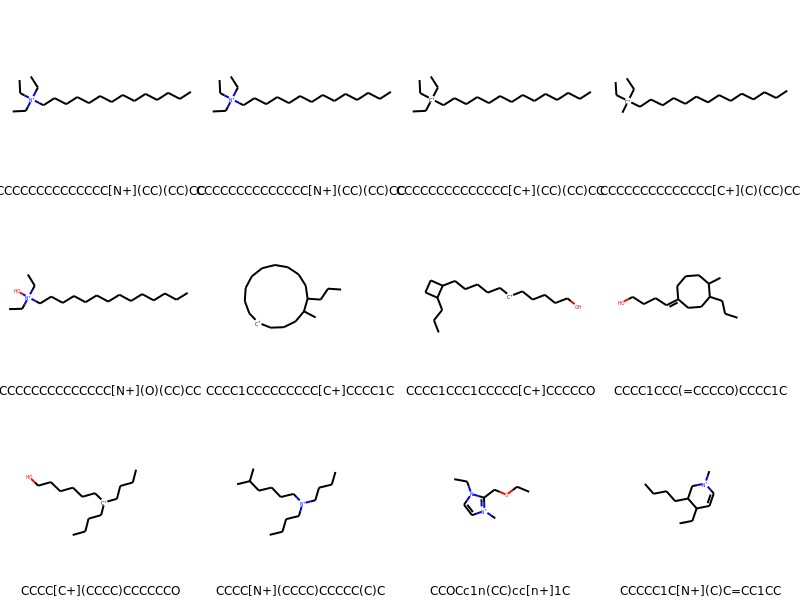

In [105]:
ms = [Chem.MolFromSmiles(smi) for smi in ms]
Draw.MolsToGridImage(ms[:],molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])

In [69]:
### From a run performed earlier... ###
ms = [cations[0], 'CCCC[C+]1C=CC(C)=C1C', 'CCCC[C+]1C=CC(CC)=C1', cations[2]]
ms = [Chem.MolFromSmiles(smi) for smi in ms]

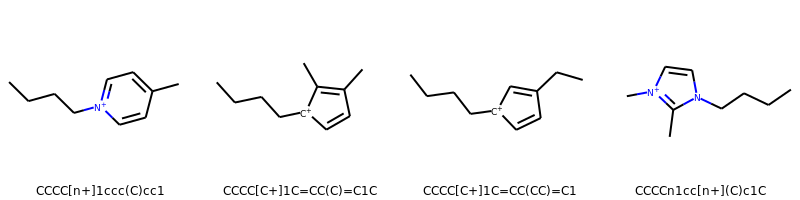

In [70]:
Draw.MolsToGridImage(ms[:4],molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:4]])

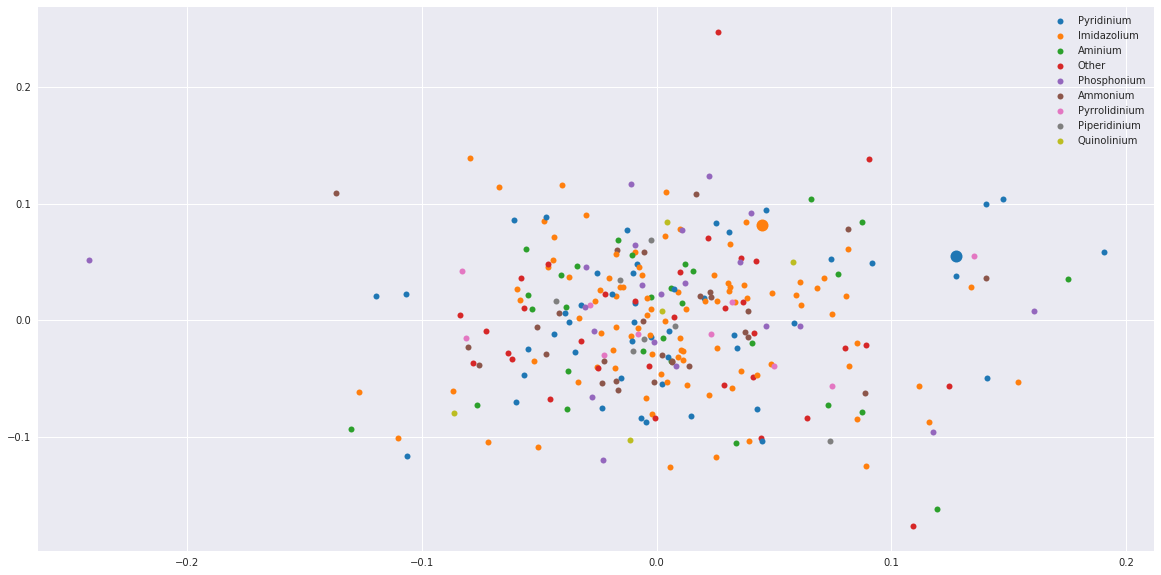

In [21]:
from collections import OrderedDict
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
for i in range(len(types)):
    if i == 0:
        ax1.plot(pca.components_[0,i], pca.components_[1,i],
                linestyle='', marker='.', color=coldic[types[i]], markersize=24, label=types[i])
    if i == 2:
        ax1.plot(pca.components_[0,i], pca.components_[1,i],
                linestyle='', marker='.', color=coldic[types[i]], markersize=24, label=types[i])
    ax1.plot(pca.components_[0,i], pca.components_[1,i],
            linestyle='', marker='.', color=coldic[types[i]], markersize=12, label=types[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

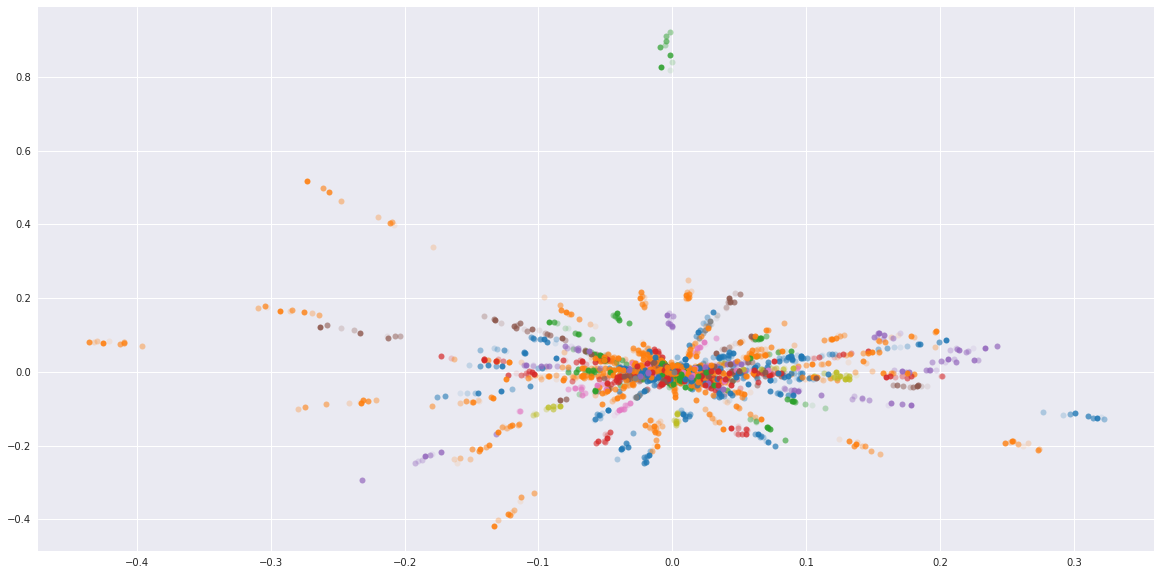

In [13]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
for peter in range(10):
    z = []
    for smi in cations:
        z_i = chemvae.encoder.predict(one_hot(smi, char_to_index))
        z.append(z_i[0])
    z = np.array(z)
    pca = PCA(n_components=2)
    pca.fit_transform(z)

    for i in range(len(categories)):
        ax1.plot(np.sum(np.dot(pca.components_[0,i],z[i,:])), 
             np.sum(np.dot(pca.components_[1,i],z[i,:])),
            linestyle='', marker='.', color=coldic[categories[i]], markersize=12, label=categories[i], alpha=peter/10)

**Continuous sampling with single seed**

In [5]:
autoencoder = build_vae()
smi = 'CCCC[n+]1ccc(cc1)C'
autoencoder.load_weights("../data/{}".format(vae_models[-1]))

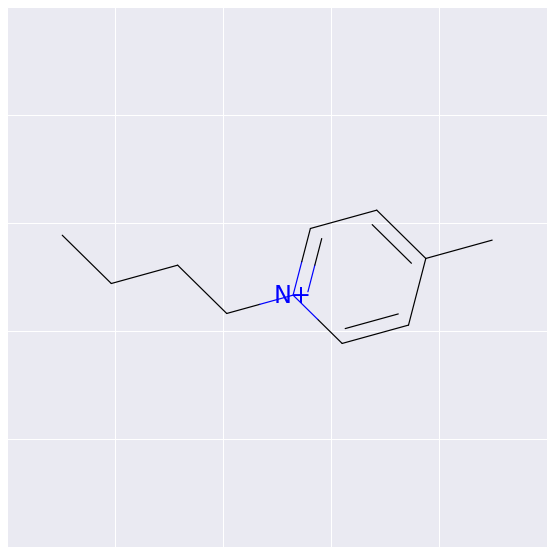

In [155]:
seed_img = Draw.MolToMPL(seed)

Text(0.5,0,'Sanitized Samples')

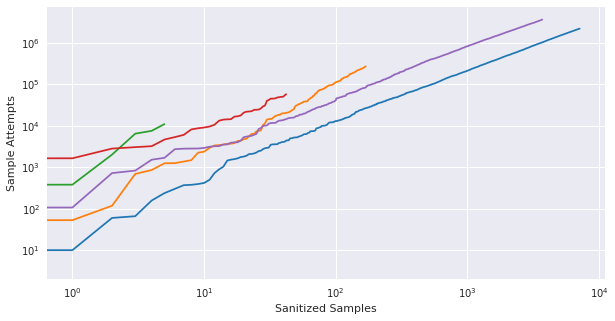

In [115]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
tab = my_colors()
for index, df in enumerate(dfs):
    df['iteration'].plot(label='{}'.format(index+1), ax=ax, loglog=True, color=next(tab))
ax.set_ylabel('Sample Attempts')
ax.set_xlabel('Sanitized Samples')
# plt.legend()

Text(-0.6,-0.5,'Temperature')

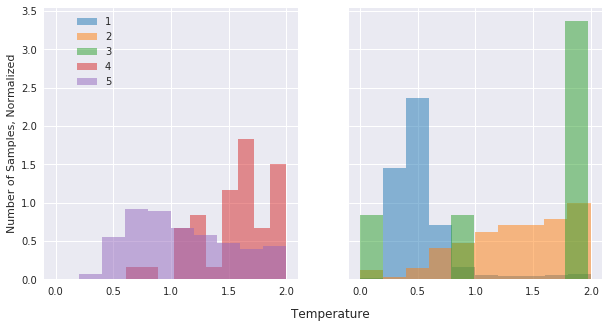

In [8]:
# fig = plt.figure(figsize=(10,10))
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212, sharey=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
tab = my_colors()
for index, df in enumerate(dfs):
    if index < 3:
        df['temperature'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax2, color=next(tab))
    else:
        df['temperature'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax1, color=next(tab))
h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(-0.9,1))
ax1.set_ylabel('Number of Samples, Normalized')
plt.text(-0.6,-0.5,'Temperature',size=12)


In [116]:
from rdkit.Chem import MACCSkeys

In [169]:
'CCCC[n+]1ccc(cc1)C' in df5['smiles']

False

In [161]:
seed = Chem.MolFromSmiles('CCCC[n+]1ccc(cc1)C')
for df in dfs:
    t_similarities=[]
    for mol in df['smiles']:
        ms = [seed, Chem.MolFromSmiles(mol)]
#         fps = [MACCSkeys.GenMACCSKeys(x) for x in ms]
#         fps = [FingerprintMols.FingerprintMol(x) for x in ms]
        fps = [Chem.rdmolops.RDKFingerprint(x, useHs=False, maxPath=7) for x in ms]
        t_similarities.append(DataStructs.FingerprintSimilarity(fps[0],fps[1]))
    df['maccs'] = t_similarities

Text(-0.67,-2,'Daylight Fingerprint Tanimoto Similarity')

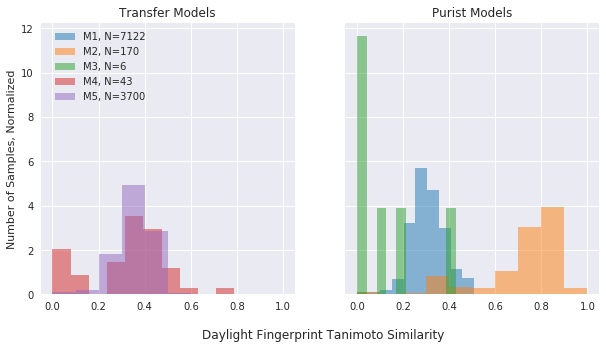

In [185]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
tab = my_colors()
for index, df in enumerate(dfs):
    if index < 3:
        df['tanimoto'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax2, color=next(tab))
    else:
        df['tanimoto'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax1, color=next(tab))
h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(-0.75,1))
ax1.set_ylabel('Number of Samples, Normalized')
ax1.set_title('Transfer Models')
ax2.set_title('Purist Models')
plt.text(-0.67,-2,'Daylight Fingerprint Tanimoto Similarity',size=12)

Text(-0.67,-2,'MACCS Fingerprint Tanimoto Similarity')

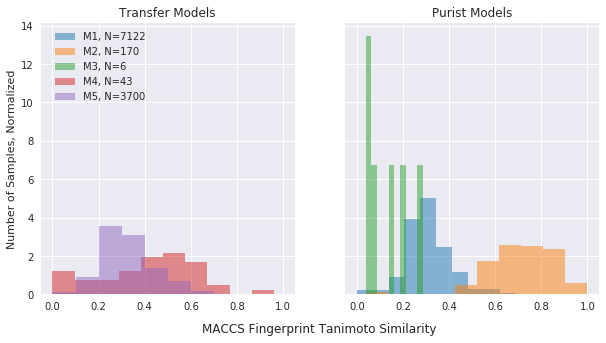

In [186]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
tab = my_colors()
for index, df in enumerate(dfs):
    if index < 3:
        df['maccs'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax2, color=next(tab))
    else:
        df['maccs'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax1, color=next(tab))
h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(-0.75,1))
ax1.set_ylabel('Number of Samples, Normalized')
ax1.set_title('Transfer Models')
ax2.set_title('Purist Models')
plt.text(-0.67,-2,'MACCS Fingerprint Tanimoto Similarity',size=12)

**But how many of these structures are relevant?**

In [40]:
for i, df in enumerate(dfs):
    ms = [Chem.MolFromSmiles(smi) for smi in df['smiles'] if '+' in smi]    
    print('{}\t positively charged molecules in M{}'.format(len(ms),i+1))
print('')
for i, df in enumerate(dfs):
    ms = [smi for smi in df['smiles'] if '+' in smi]    
    ms = [smi for smi in ms if 'C+' not in smi]
    ms = [smi for smi in ms if 'c+' not in smi]
    print('{}\t positively charged molecules in M{} w/o C+'.format(len(ms),i+1))
print('')
for i, df in enumerate(dfs):
    ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df5, df, how='inner', on='smiles')['smiles']]
    print('{}\t structures shared by M5 and M{}'.format(len(ms),i+1))

6	 positively charged molecules in M1
167	 positively charged molecules in M2
0	 positively charged molecules in M3
29	 positively charged molecules in M4
1729	 positively charged molecules in M5

0	 positively charged molecules in M1 w/o C+
167	 positively charged molecules in M2 w/o C+
0	 positively charged molecules in M3 w/o C+
28	 positively charged molecules in M4 w/o C+
807	 positively charged molecules in M5 w/o C+

94	 structures shared by M5 and M1
9	 structures shared by M5 and M2
4	 structures shared by M5 and M3
11	 structures shared by M5 and M4
3700	 structures shared by M5 and M5


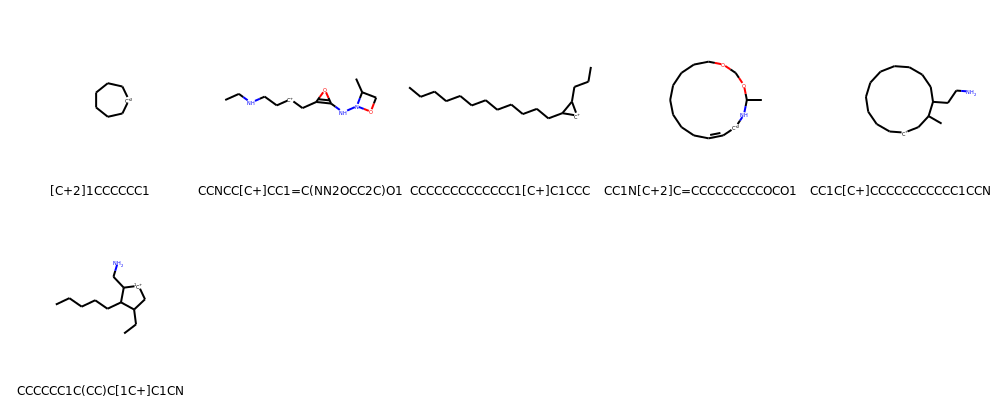

In [15]:
ms = [Chem.MolFromSmiles(smi) for smi in df1['smiles'] if '+' in smi]
Draw.MolsToGridImage(ms[:50],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:50]])

M5 sample of + structures


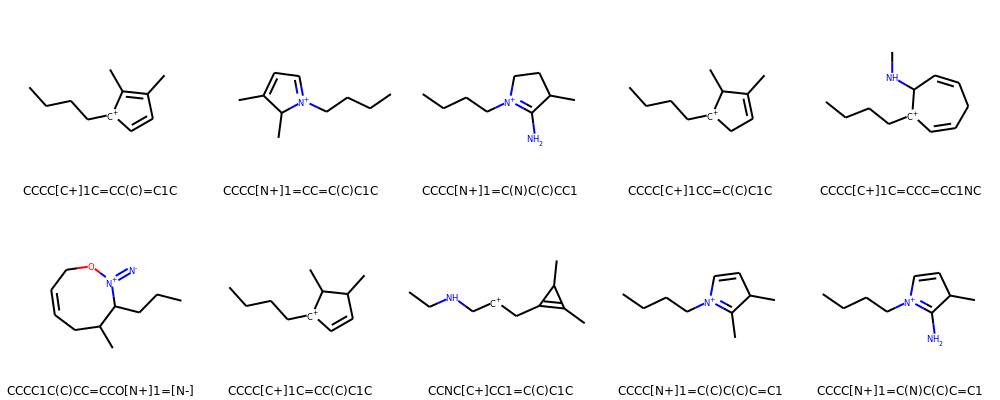

In [45]:
ms = [Chem.MolFromSmiles(smi) for smi in df5['smiles'] if '+' in smi]
print('M5 sample of + structures')
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:10]])

M2 sample of + structures


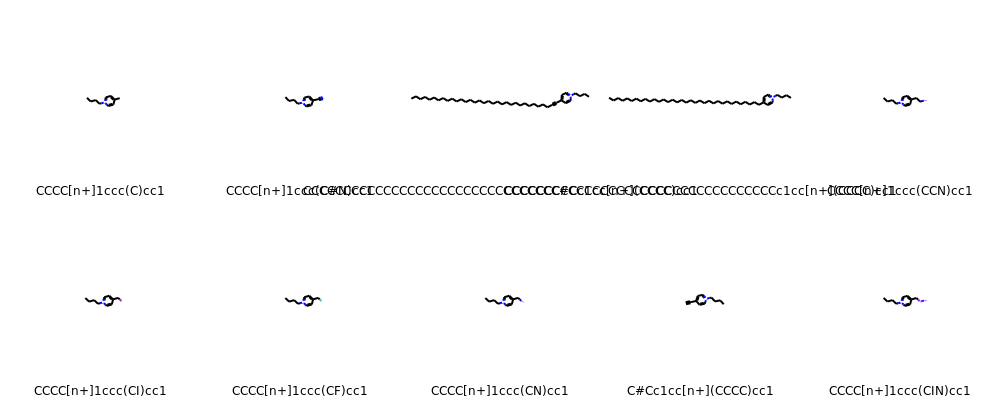

In [46]:
ms = [Chem.MolFromSmiles(smi) for smi in df2['smiles'] if '+' in smi]
print('M2 sample of + structures')
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:10]])

M4 sample of + structures


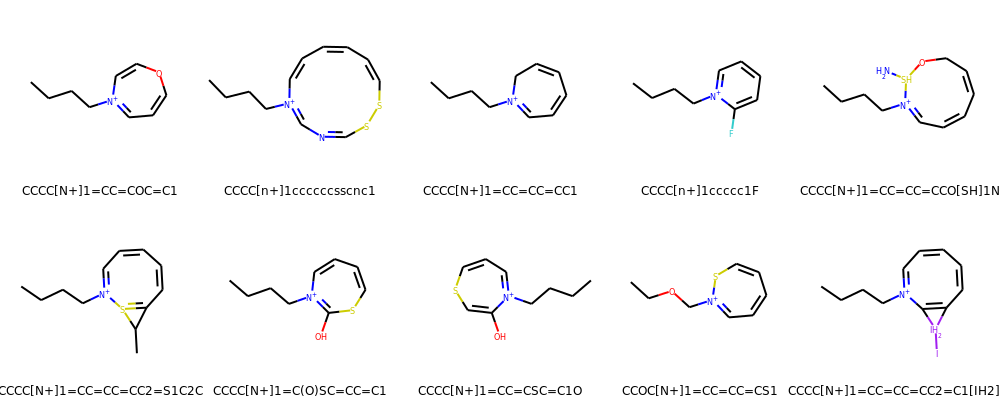

In [47]:
ms = [Chem.MolFromSmiles(smi) for smi in df4['smiles'] if '+' in smi]
print('M4 sample of + structures')
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])

94 structures shared by M5 and M1


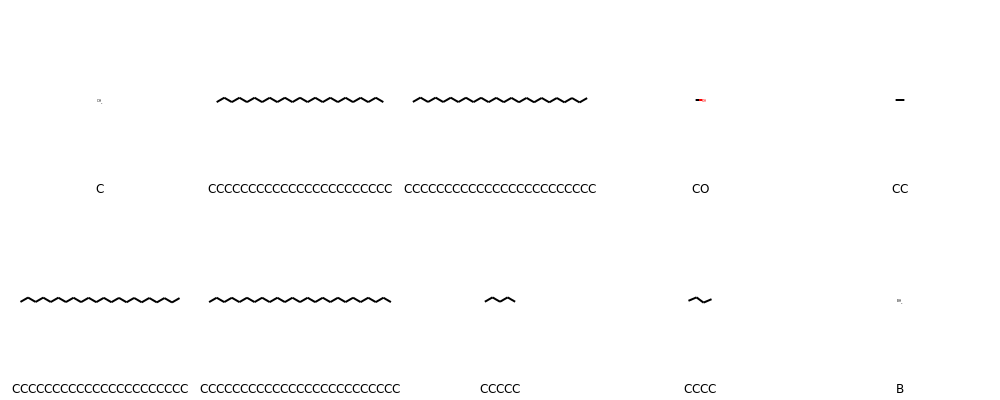

In [44]:
ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df1, df5, how='inner', on='smiles')['smiles']]
print('{} structures shared by M5 and M1'.format(len(ms)))
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])

11 structures shared by M5 and M4


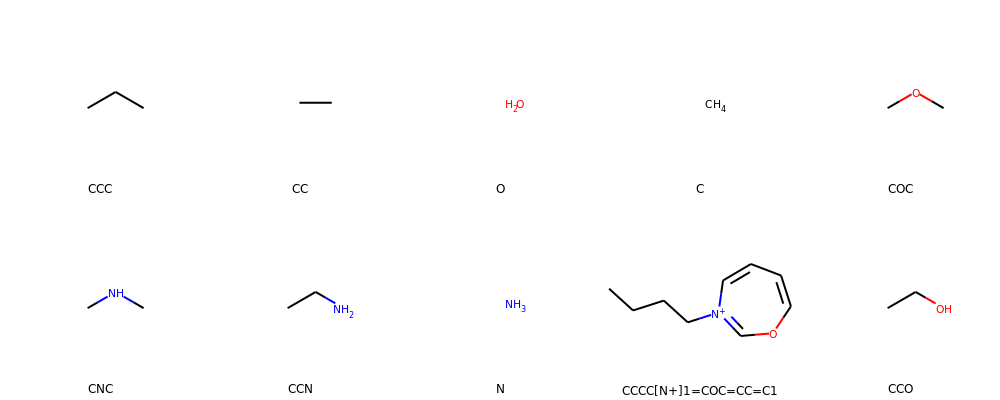

In [41]:
ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df4, df5, how='inner', on='smiles')['smiles']]
print('{} structures shared by M5 and M4'.format(len(ms)))
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])

9 structures shared by M5 and M2


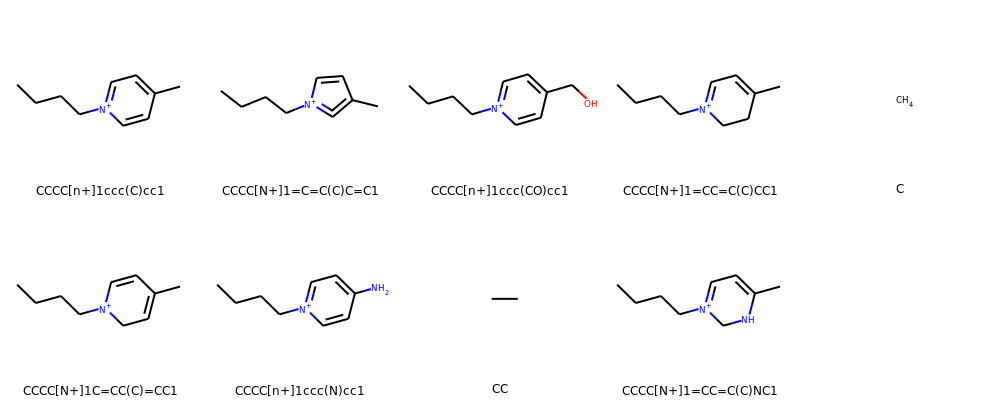

In [42]:
ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df2, df5, how='inner', on='smiles')['smiles']]
print('{} structures shared by M5 and M2'.format(len(ms)))
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])